<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Функция-расчета-прибыли" data-toc-modified-id="Функция-расчета-прибыли-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Функция расчета прибыли</a></span></li><li><span><a href="#Bootstrap" data-toc-modified-id="Bootstrap-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Bootstrap</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

# Выбор локации для скважины

**Задание**

>Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
<br><br>
Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в трех CSV файлах.
    
| column | description
| ------ | :-----------
| id | уникальный идентификатор скважины
| f0, f1, f2 | три признака точек (неважно, что они означают, но сами признаки значимы)
| product | объём запасов в скважине (тыс. баррелей)

**Условия задачи**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Импортируем необходимые для работы библиотеки.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Загрузим из файлов CSV данные по трем регионам, сохраним Их в переменные и объединим для удобства в словарь.

In [2]:
data0 = pd.read_csv('datasets\geo_data_0.csv')
data1 = pd.read_csv('datasets\geo_data_1.csv')
data2 = pd.read_csv('datasets\geo_data_2.csv')

data = {0:data0, 1:data1, 2:data2}

Просмотрим содержание данных и общую информацию по ним.

In [3]:
for df in data.values():
    display(df.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
for reg, df in data.items():
    print('Region', reg+1, '\n', '-' * 15)
    df.info()
    print()

Region 1 
 ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Region 2 
 ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Region 3 
 ---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

Каждая таблица представлена 100 тысячами записей, без пропусков в столбцах. Среди столбцов имеется *id* - обозначение каждой точки, три параметра *f0, f1, f2* - они обозначают значимые признаки точек и *product* - объем запасов продукта в точке. *product* является целевым признаком, *f0, f1, f2* - обучающие признаки.

Проверим таблицы на наличие дубликатов.

In [5]:
for reg, df in data.items():
    print(f'Region {reg+1}',
          '-' * 15,
          f'duplicated   {df.duplicated().sum()}',
          df[['id']].nunique(), sep='\n', end='\n\n')

Region 1
---------------
duplicated   0
id    99990
dtype: int64

Region 2
---------------
duplicated   0
id    99996
dtype: int64

Region 3
---------------
duplicated   0
id    99996
dtype: int64



Среди идентификаторов точек в каждом регионе есть повторы, причем полных дубликатов строк в таблице нет. Это может указывать на несколько раз проведенные замеры точек. Не будем изменять эти данные.

In [6]:
def describe_df(data):
    df = data[1]
    print(f'Region {data[0]+1}')
    display(df.describe(), 'Correlation matrix')
    plt.figure(figsize=(7, 6))
    sns.heatmap(df.corr(), linewidths=.5, cmap='vlag', annot=True, fmt='2.4f', vmin=-1)
    plt.show()

Region 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Correlation matrix'

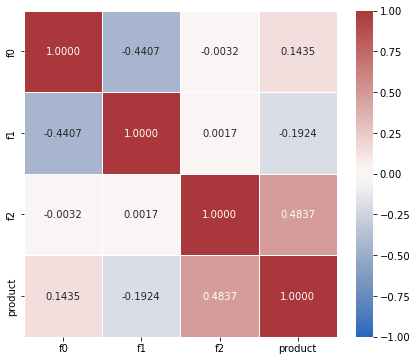

In [7]:
desc_corr = (describe_df(df) for df in data.items())
next(desc_corr)

В первом регионе можно наблюдать среднюю корреляцию между признаком *f2* и *product* (0.48). Признаки *f0* и *f1* имеют среднюю отрицательную корреляцию между собой (-0.44).

Region 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Correlation matrix'

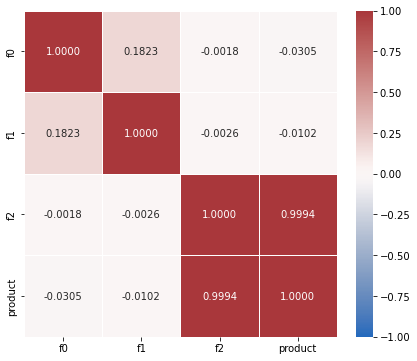

In [8]:
next(desc_corr)

**Во втором регионе корреляция между *f2* и *product* приближается к 1**. Между этими параметрами существует прямая линейная зависимость. Необходимо дополнительно исследовать данные для второго региона.

Region 3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'Correlation matrix'

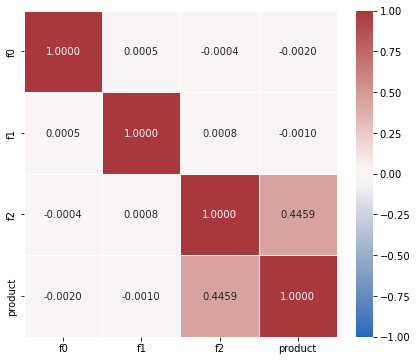

In [9]:
next(desc_corr)

В третьем регионе корреляция между *f2* и *product* похожа на первый регион (0.45). Коэффициенты среди всех остальных признаков близятся у нулю.

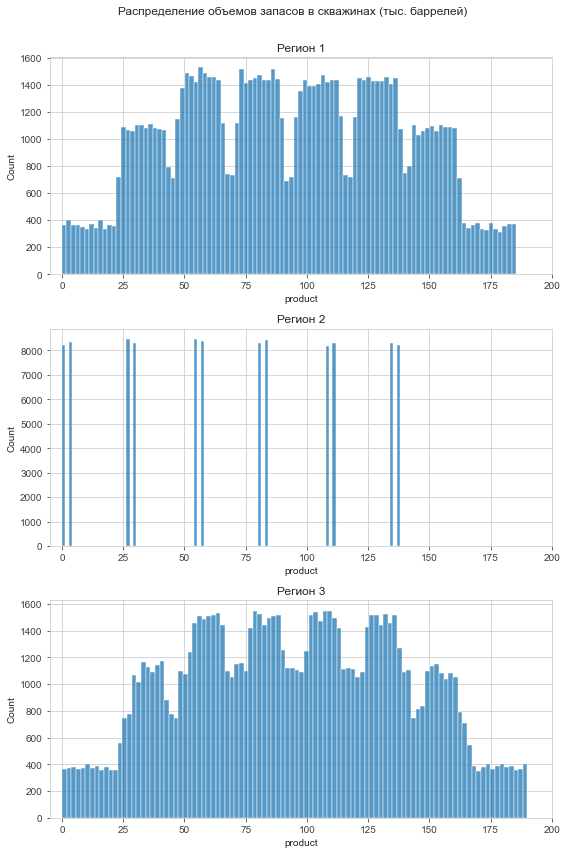

In [10]:
sns.set_style("whitegrid", {'ytick.left': True, 'xtick.bottom':True, 'xtick.color': '.25', 'ytick.color': '.25'})
fig, ax = plt.subplots(3, 1, figsize=(9, 14))
plt.subplots_adjust(hspace=0.25)

for reg, df in data.items():
    sns.histplot(df['product'], ax=ax[reg], bins=100)
    ax[reg].set_title(f'Регион {reg+1}')
    ax[reg].set_xlim(-5, 200)
    
fig.suptitle('Распределение объемов запасов в скважинах (тыс. баррелей)', y=0.93)
plt.show()

Из графиков распределения значений *product* по регионам можно отметить дискретность данных - графики имеют шесть пиков. Вероятные объяснения такого характера распределения могут быть: 
- особенности техники измерения запасов сырья, когда один важный фактор определяет запасы одним из ряда чисел, а другие факторы немного корректируют это число в большую или меньшую сторону;
- принадлежность точек измерения к одному из нескольких крупных месторождений в регионе, чьи общие запасы сильно отличаются друг от друга.

**График для второго региона представляет собой дискретное распределение**. Признак *product* может принимать одно из двенадцати значений.

In [11]:
display(data[1]['product'].value_counts())
print('Регион 2\nЧисло дискретных значений:', data[1]['product'].value_counts().count())

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

Регион 2
Число дискретных значений: 12


Признак *product* для второго региона практически равномерно распределен по 12 значениям, определенным до миллионных долей. Следует обратить внимание команды, отвечающей за сбор информации на этот факт. Такое качество данных может привести к некорректной работе модели в этом регионе и невозможности сравнения с результатами других регионов.

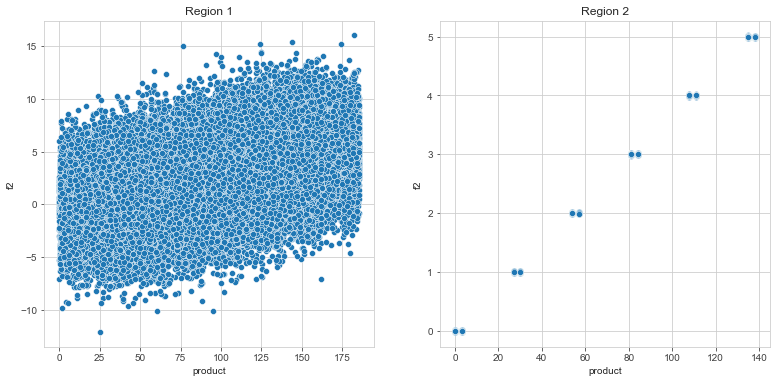

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
sns.scatterplot(data=data[0], x='product', y='f2', ax=ax[0])
ax[0].set_title('Region 1')
sns.scatterplot(data=data[1], x='product', y='f2', ax=ax[1])
ax[1].set_title('Region 2')
plt.show()

График зависимости признака *f2* и *product* показывает, что *f2* также дискретная величина и состоит из 6 различных значений, близким к целым числам. На графике справа наглядно видна прямолинейная зависимость *f2* и *product*. Слева график для первого региона, где признаки имеют более случайные значения.

### Вывод

В ходе исследования распределений целевого признака было обнаружено, что данные для второго региона сильно отличаются от других регионов. Таблица содержит 12 значений *product* и 6 значений признака *f2*. Последний признак полностью коррелирует с целевым признаком. **Обучать предсказательные модели на данных для второго региона не имеет практического смысла** - модель будет с очень высокой точностью предсказывать целевой признак, но в данном случае он очевиден.

## Обучение и проверка модели

Обучим модель линейной регрессии на данных по каждому региону и составим таблицу метрик модели.

In [13]:
metrics_data = {'r2':[], 'rmse':[], 'predicted_mean':[], 'target_mean':[]}
region_predictions = []

for reg, df in data.items():
    # split data into train and valid
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    # split data into training and test sets
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    # fit model on training set
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = LinearRegression()
        model.fit(features_train, target_train)  
    
    # calculate metrics
    predictions = model.predict(features_valid)
    region_predictions.append(pd.Series(index=target_valid.index, data=predictions))
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    
    metrics_data['r2'].append(r2_score(target_valid, predictions))
    metrics_data['rmse'].append(rmse)
    metrics_data['predicted_mean'].append(predictions.mean())
    metrics_data['target_mean'].append(target_valid.mean())

In [14]:
region_metrics = pd.DataFrame(metrics_data, index=['region_1', 'region_2', 'region_3']).T
region_metrics

,region_1,region_2,region_3
r2,0.279943,0.999623,0.205248
rmse,37.579422,0.893099,40.029709
predicted_mean,92.592568,68.728547,94.965046
target_mean,92.078597,68.723136,94.884233


В целом предсказанное среднее очень похоже во всех регионах на истинные значения. Метрика R2 больше, а метрика RMSE меньше в первом регионе, по сравнению с третьим.

## Подготовка к расчёту прибыли

Чтобы оценить прибыльность разработки той или иной скважины, нужно сравнить ее потенциальную прибыль с некой величиной.  Для сравнения расчитаем точку безубыточности - запас продукта, стоимость которого покроет расходы на разработку.

Запишем исходные параметры для расчета прибыли в переменные.

In [15]:
BUDGET = 1e10
TOTAL_POINTS = 500
TOTAL_BEST_POINTS = 200
PRODUCT_PROFIT = 450 * 1e3
MAX_LOSS_RISK = 0.025

Компания будет вести разработку в 200 точках, тогда бюджет на разработку одной точки равен:

$$well\_development\_budget = \frac{budget}{total\_best\_points}$$

Зная доход от продажи тысячи баррелей продукта, определим минимальный запас скважины, необходимый для окупаемости разработки:

$$min\_product = \frac{well\_development\_budget}{product\_profit}$$

In [16]:
WELL_DEVELOPMENT_BUDGET = BUDGET / TOTAL_BEST_POINTS
MIN_PRODUCT = WELL_DEVELOPMENT_BUDGET / PRODUCT_PROFIT

print('Минимальный запас скважины для безубыточной разработки: {:.2f} тыс. баррелей'.format(MIN_PRODUCT))

Минимальный запас скважины для безубыточной разработки: 111.11 тыс. баррелей


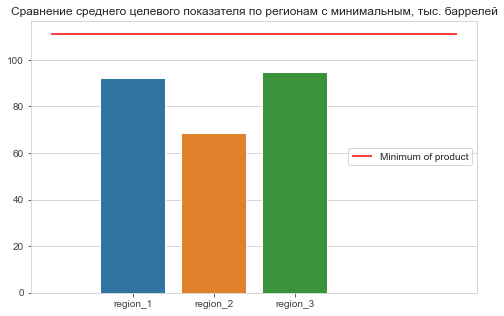

In [17]:
fig,ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=region_metrics.loc[['target_mean']])
ax.hlines(MIN_PRODUCT, -1, 4, color='r', label='Minimum of product')
plt.legend(loc='center right')
_ = ax.set_title('Сравнение среднего целевого показателя по регионам с минимальным, тыс. баррелей')

Минимальный запас продукта скважины необходимый для безубыточности разработки равен 111.1 тыс. баррелей. **Средние показатели запасов во всех регионах ниже минимального количества для окупаемости.**

### Вывод

Метрики модели линейной регрессии имеют лучшие показатели в первом регионе, по сравнению с третьим. Предсказания модели имеют среднее значения очень близкое к истинным средним. Корень из средней квадратичной ошибки составляет около 40% от среднего значения в первом и третьем регионах. Результаты по второму региону значительно отличаются от остальных, данные для обучения модели имеют иную структуру, чем в других регионах. Из сравнения результатов второго региона нельзя сделать значащие выводы. 

## Расчёт прибыли и рисков 

### Функция расчета прибыли

Напишем функцию для определения прибыли в регионе с учетом затрат на разработку скважин. Используем в функции предсказания модели линейной регрессии, для определения наиболее выгодных точек разработки.

In [18]:
def profit(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target.loc[predictions_sorted.index][:count]
    return ((selected.sum() * PRODUCT_PROFIT) - BUDGET) / 1e9

Применим функцию для каждого региона.

In [19]:
region_profit = []
print('Прибыль 200 скважин выбранных по предсказаниям модели с учетом стоимости разработки скважин:')
for i in range(3):
    result = profit(data[i]['product'], region_predictions[i], TOTAL_BEST_POINTS)
    region_profit.append(result)
    print('Регион {} - {:.2f} млрд. руб.'.format(i+1, result))

Прибыль 200 скважин выбранных по предсказаниям модели с учетом стоимости разработки скважин:
Регион 1 - 3.32 млрд. руб.
Регион 2 - 2.42 млрд. руб.
Регион 3 - 2.71 млрд. руб.


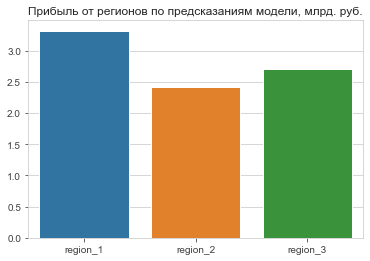

In [20]:
ax = sns.barplot(x=['region_1', 'region_2', 'region_3'], y=region_profit)
_ = ax.set_title('Прибыль от регионов по предсказаниям модели, млрд. руб.')

При выборе разрабатываемых скважин по предсказаниям модели наиболее прибыльным регионом оказался первый. За ним третий регион.

### Bootstrap

Применим технику Bootstrap с 1000 выборок, чтобы определить прибыльность регионов. Напишем функцию, которая применяет Bootstrap к данным региона и считает метрики: среднюю прибыль, риск убытков и доверительный интервал 95%. Для определения доверительного интервала воспользуемся методом квантилей.

In [21]:
def bootstrap_region(region, rs=12345):
    state = RandomState(rs)
    values = []
    target = data[region]['product'].loc[region_predictions[region].index]
    
    for i in range(1000):
        target_subsample = target.sample(n=TOTAL_POINTS, replace=True, random_state=state)
        predict_subsample = region_predictions[region][target_subsample.index]
        values.append(profit(target_subsample, predict_subsample, TOTAL_BEST_POINTS))

    values = pd.Series(values)
    mean_profit = values.mean()
    loss_risk = (values < 0).mean() 

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    return (mean_profit, loss_risk, lower, upper)

Применим функцию для каждого региона и составим таблицу метрик.

In [22]:
bootstrap_result = []
for region in range(3):
    bootstrap_result.append(bootstrap_region(region))
    
bootstrap_data = pd.DataFrame(index=['region_1', 'region_2', 'region_3'], 
                              columns=['mean_profit', 'loss_risk', 'min_ci', 'max_ci'], 
                              data=bootstrap_result)
bootstrap_data

,mean_profit,loss_risk,min_ci,max_ci
region_1,0.425939,0.060,-0.102090,0.947976
region_2,0.515223,0.010,0.068873,0.931548
region_3,0.435008,0.064,-0.128881,0.969707


Отфильтруем регионы по признаку риска убытков - 2.5%

In [23]:
acceptable_regions = bootstrap_data.query('loss_risk < @MAX_LOSS_RISK').sort_values('mean_profit', ascending=False)
acceptable_regions

,mean_profit,loss_risk,min_ci,max_ci
region_2,0.515223,0.01,0.068873,0.931548


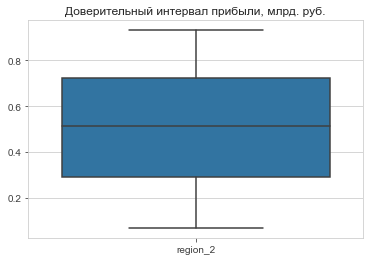

In [24]:
ax = sns.boxplot(data=acceptable_regions[['mean_profit', 'min_ci', 'max_ci']].T)
ax.set_title('Доверительный интервал прибыли, млрд. руб.')
plt.show()

### Вывод

Мы посчитали риски и прибыли для трех регионов. Техникой Bootstrap получили значения средней прибыли, риска убытков и доверительный интервал 95% для каждого региона.
- Все регионы показали положительную среднюю прибыль. Наибольшая средняя прибыль наблюдается во втором регионе 0.52 млрд., далее третий 0.44 млрд. и первый регионы 0.43 млрд. руб.
- По значению риска убытков, меньше максимального значения 2.5% только во втором регионе - 1.0%. В первом регионе 6.0%, в третьем 6.4%.
- Нижняя граница доверительного интервала иллюстрирует, что риск убытков в первом и третьем регионах выше требуемого значения, а именно нижняя граница отрицательная в первом и третьем регионах.

Заявленным в задании требованиям соответствует только **второй регион**. Однако, однозначно делать вывод по результатам анализа нельзя. Исходные данные для этого региона вызывают сомнения в адекватности реальной ситуации. Необходимо уточнить данные по региону и, либо провести анализ по уточненным данным, либо исключить второй регион из выбора. Из прочих регионов **ни один не соответствует заявленным требованиям** и не может быть рекомендован для разработки.